In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Read the CSV

In [ ]:
img_folder = '../input/cassava-leaf-disease-classification/train_images/'
train_df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_df.head()

In [ ]:
label_count = train_df.label.value_counts()
plt.figure(figsize=(6, 3))
sns.set_palette("mako")
sns.countplot(x="label", data=train_df)
plt.title('label count')
print(f'total images: {train_df.shape[0]}')
print(f'class 3 has {label_count[3]/label_count.sum()*100 :.2f}% of images')

given only label category, this would be a simple multi-class classification task<br>
ways of improving would be:
- augmentation
- external dataset
- balancing the dataset (currently bias to class 3)

In [ ]:
cat = [
    "Cassava Bacterial Blight (CBB)",
    "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)",
    "Cassava Mosaic Disease (CMD)",
    "Healthy"
]

# Viewing leaves
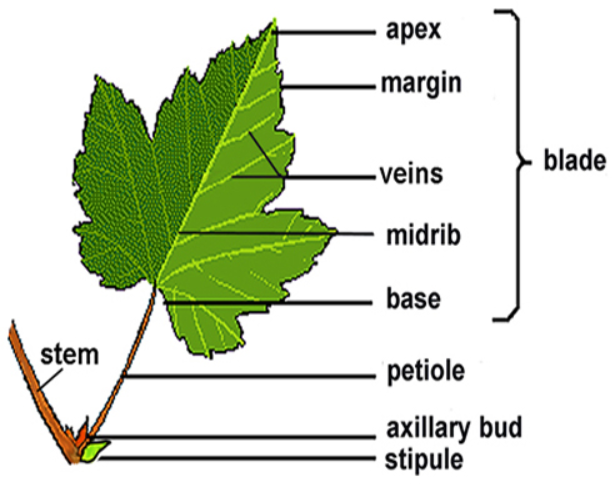
leaf structure, source: [The Leaf: Site of Photosynthesis & Transpiration](http://www.bio.miami.edu/dana/dox/leaf.html)

as confirmed by others, all images have res of 800x600 (wxh)

In [ ]:
def getImage(path):
    img = tf.io.read_file(path)
    return tf.image.decode_jpeg(img, channels=3)
    
def getImageFromLabel(label, n, seed=3):
    img_ids = train_df.image_id[train_df.label == label].sample(n,random_state=seed).to_numpy()
    f = plt.figure(figsize=(25,5))
    for i,img_id in enumerate(img_ids):
        ax = f.add_subplot(1,n,i+1)
        ax.imshow(getImage(img_folder+img_id))
        ax.set_title(img_id)
        ax.axis("off")
    f.suptitle(cat[label], fontsize=24)
    plt.show()

## Cat 4: Healthy
quick obs: green color looks fresh, not much color variance of the blades

In [ ]:
getImageFromLabel(4, 6)

## Cat 0: CBB
quick obs: some yellow areas near the end, brownish spots

In [ ]:
getImageFromLabel(0, 6)

## Cat 1: CBSD
quick obs: yellow patches and stripes on the leaves

In [ ]:
getImageFromLabel(1, 6)

## Cat 2: CGM
quick obs: almost similar like cat 1, but with thinner patterns along the veins

In [ ]:
getImageFromLabel(2, 6)

## Cat 3: CMD
quick obs: yellow area around the base, spreading along the midrib, largest category in the dataset

In [ ]:
getImageFromLabel(3, 6)

# Image statistics
* created by Aditya [[source](https://www.kaggle.com/fireheart7/cassavaimagestatistics)]
* found duplicate images using imageHash [[source](https://www.kaggle.com/nakajima/duplicate-train-images)]


In [ ]:
stats_df = pd.read_csv('../input/cassavaimagestatistics/train_image_statistics.csv')
# add label column to the stats
stats_df = stats_df.merge(train_df, left_on='image_name', right_on='image_id')
stats_df = stats_df.drop(['image_id'], axis=1)
stats_df.head()
stats_df[stats_df.image_mean.duplicated(keep=False)]

In [ ]:
# from stats
pair1 = ['2161216430.jpg','1882441539.jpg']
pair2 = ['895356426.jpg', '1470037662.jpg']
# from imagehash
pair3 = ['1562043567.jpg', '3551135685.jpg']
pair4 = ['2252529694.jpg', '911861181.jpg']
def plotPair(img_ids):
    f,ax = plt.subplots(1,2,figsize=(10,5))
    for i,img_id in enumerate(img_ids):
        label = stats_df.label[stats_df.image_name==img_id].values[0]  # grab the label
        img = tf.io.read_file(img_folder+img_id)  # read img
        img = tf.image.decode_jpeg(img)
        ax[i].imshow(img)
        ax[i].set_title(f'cat: {label}')

plotPair(pair1)
plotPair(pair2)
plotPair(pair3)
plotPair(pair4)

In [ ]:
# let's see the stats of duplicate pair3
stats_df[stats_df.image_name.isin(pair3)]

# Duplicates?
* pair 3 and 4 definitely are duplicates. they're same images but their pixel statistics are not exactly the same
* pair 1 and 2 is unlikely, although they weirdly has the same pixel mean
* interestingly in pair 3, both have different class, so which one should we trust? better just drop both IMO

In [ ]:
# drop pair 3 and one of pair 4
drop_img = ['1562043567.jpg', '3551135685.jpg', '2252529694.jpg']
drop_df = train_df[train_df.image_id.isin(drop_img)]
train_df2 = train_df.drop(index=drop_df.index)
train_df2.shape

## Least green images
since it's about leaves, what if we plot images that have the least amount of 'green'

In [ ]:
green_imgs = stats_df.sort_values(['mean_green_value'])[:15]
green_imgs = green_imgs[['image_name','label']].to_numpy()
plt.figure(figsize=(25,12))
for i,row in enumerate(green_imgs):
    plt.subplot(3,5,i+1)
    img = getImage(img_folder+row[0])
    plt.imshow(img)
    plt.title(f'{row[0]}: {row[1]}')
    plt.axis('off')

- looks like some images from category 1 has focus on the cassava roots instead of the leaves
- these images have a lot of dark areas. this makes sense, since dark pixel have values near 0
- dark areas are either because of night time, or strong shadows in a bright day

# Clustering based on statistics
using K-means, inspired by this [awesome notebook](https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-image-statistics)

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5
num_sample = 8
kmeans = KMeans(n_clusters=num_clusters, 
                random_state=0)

x = stats_df.loc[:, ["image_mean", "image_sd", "image_skewness",
                     'mean_red_value', 'mean_green_value', 
                     'mean_blue_value']].values
cluster_labels = kmeans.fit_predict(x)
stats_df["cluster_label"] = cluster_labels
stats_df.head()

In [ ]:
fig, ax = plt.subplots(num_clusters, num_sample, figsize=(20, 2.5*num_clusters))

for cluster in range(num_clusters):
    # grab a sample from the each clusters
    selection = stats_df[stats_df.cluster_label==cluster].sample(num_sample, random_state=5)
    # for plotting, get only img_id and label
    selection = selection[['image_name','label']].to_numpy()
    m=0
    for img_id,label in selection:
        image = getImage(img_folder+img_id)
        ax[cluster, m].imshow(image)
        ax[cluster, m].set_title(f'cluster: {cluster}, cat: {label}')
        ax[cluster, m].axis("off")
        m+=1


In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=stats_df,
                x=stats_df.image_mean.values,
                y=stats_df.image_sd.values,
                hue=stats_df.cluster_label,
                palette='bright')
plt.xlabel('mean')
plt.ylabel('std')
plt.title('Clustering based on K-means')
plt.show()

In [ ]:
# scatterplot based on labels
plt.figure(figsize=(12,5))
sns.scatterplot(data=stats_df,
                x=stats_df.image_mean.values,
                y=stats_df.image_sd.values,
                hue=stats_df.label,
                palette='bright')
plt.xlabel('mean')
plt.ylabel('std')
plt.title('Clustering from labels')
plt.show()

# On progress..